# Simulation Experiments

$\large{\textbf{Cluster randomization}}$

Induce contamination by changing x% of the control arm indicator to intervention. Evaluate if this approach of inducing contamination agrees with the closed-form formula.

In [1]:
tab_fig_path='/burg/biostats/users/ek3235/RCTcontamination/contamiation_in_rct/tables_and_figures/'

In [2]:
source('utils.r') # heritable functions. Add plot functions later

Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loading required package: foreach

Loading required package: iterators



$\large{\textbf{Why way? Individual or cluster rct? }}$

Examine critical rate of contamination before the sample size required for individual rct with contamination becomes larger than cluster rct. For this, implement the functions in 'Hemming, Karla, et al. "Contamination: How much can an individually randomized trial tolerate?." Statistics in Medicine 40.14 (2021): 3329-3351.'

This happens when 

$$ 2\sigma^2 \left[\frac{(z_{\alpha/2}+z_{\beta}  )^2}{ ((1-\omega)\delta)^2 } \right] >2\sigma^2 \left[\frac{(z_{\alpha/2}+z_{\beta}  )^2}{ \delta^2 } \right] [1+(m-1) \rho] $$

where m is the cluster size and $\rho$ is the intra-cluster correlation (icc). 

For consistency with a real-life clinical setting where the number of doctors are usually fixed, we can convert the formula above to be a function of $k$, the number of clusters as opposed to the number of subjects per cluster (i.e., cluster size). 

Let 

$$n_i=2\sigma^2 \left[\frac{(z_{\alpha/2}+z_{\beta}  )^2}{ \delta^2 } \right]$$ 

Then 

$$\frac{n_i}{(1-\omega)^2} > n_i[1+(m-1) \rho]  $$

$\Longleftrightarrow$

$$ \frac{n_i}{(1-\omega)^2} > n_i \frac{k(1-\rho)}{[k-n_i\rho]}$$

$\Rightarrow$

$$\omega > 1- \sqrt{ \frac{k-n_i\rho}{ k(1-\rho)} } $$

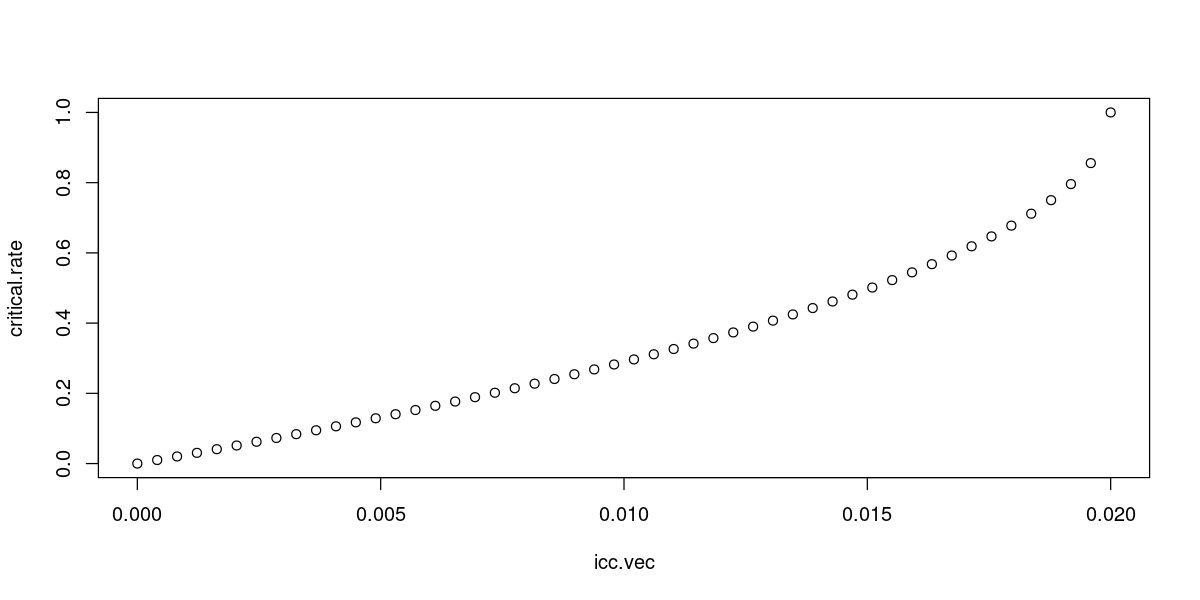

In [3]:
# critical rate of contamination function 

critical.rate.of.cantamin.by.k=function(ni, k, icc){ # using number of clusters instead of cluster size

    t2=sqrt( (k-ni*icc)/( k*(1-icc) ) ) 
    crc=1-t2
    
    return(crc)
}


critical.rate.of.cantamin.by.m=function(m, icc){ 

    t2=1/sqrt( 1+ ( (m-1)*icc) ) 
    crc=1-t2
    
    return(crc)
}



ni=500
k=10
icc=k/ni

m=ni/k


#critical.rate.of.cantamin.by.k(ni=ni, k=k, icc=icc)

#critical.rate.of.cantamin.by.m(m=m, icc=icc)

critical.rate=NULL 

icc.vec=seq(0, k/ni, length.out=50)
for ( i in 1:length(icc.vec) ){
    
    critical.rate[i]=critical.rate.of.cantamin.by.k(ni=ni, k=k, icc=icc.vec[i] )
}

options(repr.plot.width = 10, repr.plot.height =5) 
plot(x=icc.vec, y=critical.rate)


# critical.rate.m=NULL 
# icc.vec=seq(0, 0.2, length.out=50)
# m=20
# for ( i in 1:length(icc.vec) ){
    
#     critical.rate.m[i]=critical.rate.of.cantamin.by.m(m=m, icc=icc.vec[i] )
# }
# options(repr.plot.width = 7, repr.plot.height =5) 

# plot(x=icc.vec, y=critical.rate.m, ylim=c(0,1), type='l')


In [4]:
# collect results for the following combinations of sample size and number of clusters 
# bad coding but it will do for now. 

ni.vec=c(500, 1000, 1500)
no.cluster=c(10, 30, 50)

 
critical.rate.ni.k.icc=function(ni, k){ 
    
    critical.rate=NULL 
    
    icc.vec=seq(0, k/ni, length.out=50)
    
    for ( i in 1:length(icc.vec) ){

        critical.rate[i]=critical.rate.of.cantamin.by.k(ni=ni, k=k, icc=icc.vec[i] )
    }
    
    return (critical.rate)

}


critical.rate.df=data.frame()

len.out=50
for (j in 1:length(ni.vec)){
    
    temp1=rep(ni.vec[j], len.out)
    
    temp.df=data.frame() # where to store data for each cluster for one ni
    
    for(c in 1:length(no.cluster) ){
        
        temp2=critical.rate.ni.k.icc(ni=ni.vec[j],k=no.cluster[c]) # critical rate of contamination for ni and k 
        
        temp3=rep(no.cluster[c], length(len.out) ) # corresponding number of clusters 
        
        temp4=seq(0, no.cluster[c]/ni.vec[j], length.out=50) # correspond icc upto the limit. 
        
        temp.df=rbind(temp.df, data.frame(critical.rate=temp2, ni=temp1, no.cluster=temp3, icc=temp4))
    }
    
    critical.rate.df=rbind(critical.rate.df, temp.df) 
}

head(critical.rate.df); tail(critical.rate.df)

,critical.rate,ni,no.cluster,icc
,<dbl>,<dbl>,<dbl>,<dbl>
1,0.00000000,500,10,0.0000000000
2,0.01005463,500,10,0.0004081633
3,0.02022078,500,10,0.0008163265
4,0.03050196,500,10,0.0012244898
5,0.04090190,500,10,0.0016326531
6,0.05142449,500,10,0.0020408163


,critical.rate,ni,no.cluster,icc
,<dbl>,<dbl>,<dbl>,<dbl>
445,0.6756709,1500,50,0.02993197
446,0.7098095,1500,50,0.03061224
447,0.7485994,1500,50,0.03129252
448,0.7946602,1500,50,0.03197279
449,0.8547518,1500,50,0.03265306
450,1.0000000,1500,50,0.03333333


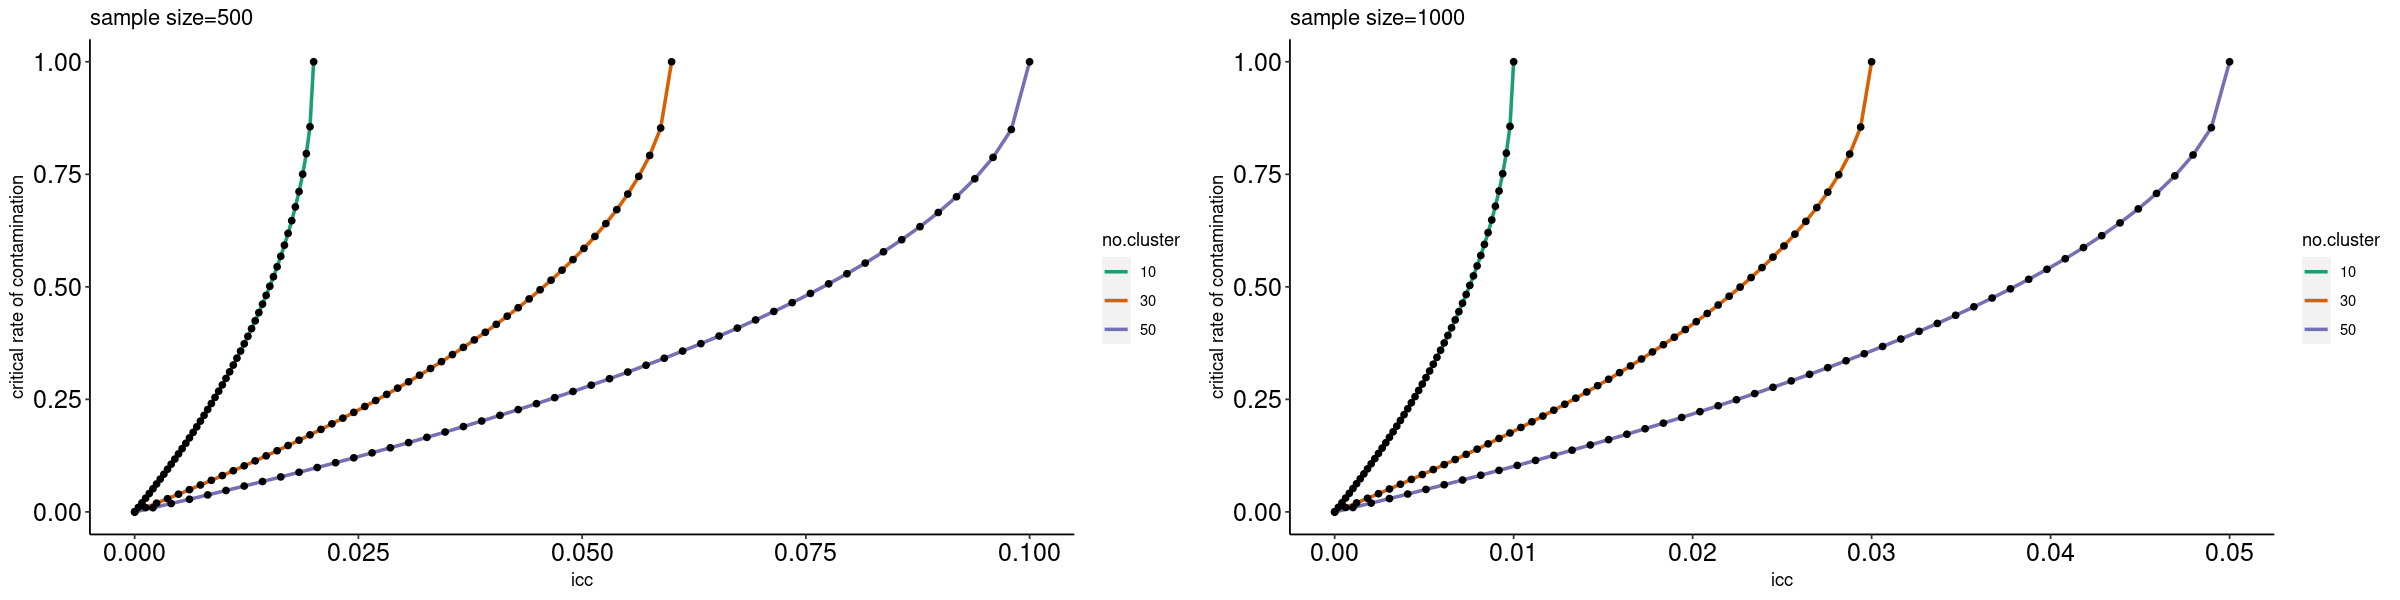

In [5]:
# plot critical rate vs icc colored by number of clusters separated by sample sizes 
critical.rate.df$no.cluster=as.factor(critical.rate.df$no.cluster)
critical.rate.df.500=critical.rate.df[critical.rate.df$ni==500, ]

options(repr.plot.width = 20, repr.plot.height =5) 

plot.500=ggplot(critical.rate.df.500, aes(x=icc, y=critical.rate, group=no.cluster)  )+
geom_line(aes(
    color=no.cluster
), lwd=1.0)+
geom_point()+scale_color_brewer(palette="Dark2")+
ylim(0,1)+
#xlim(0, 1)+
labs(x="icc",y="critical rate of contamination")+
theme(axis.text.x = element_text(#face = "bold", 
                            color ="black", 
                           size = 15, angle = 0), 
     axis.text.y = element_text(color ="black", 
                           size = 15,))+
ggtitle( paste0('sample size=',critical.rate.df.500$ni[1]))+theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
panel.background = element_blank(), axis.line = element_line(colour = "black"))


# ni=1000
critical.rate.df.1000=critical.rate.df[critical.rate.df$ni==1000, ]

plot.1000=ggplot(critical.rate.df.1000, aes(x=icc, y=critical.rate, group=no.cluster)  )+
geom_line(aes(
    color=no.cluster
), lwd=1.0)+
geom_point()+scale_color_brewer(palette="Dark2")+
ylim(0,1)+
#xlim(0, 1)+
labs(x="icc",y="critical rate of contamination")+
theme(axis.text.x = element_text(#face = "bold", 
                            color ="black", 
                           size = 15, angle = 0),
     axis.text.y = element_text(color ="black", 
                           size = 15,))+
ggtitle( paste0('sample size=',critical.rate.df.1000$ni[1]))+theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
panel.background = element_blank(), axis.line = element_line(colour = "black"))


critical.rate.df.1500=critical.rate.df[critical.rate.df$ni==1500, ]

plot.1500=ggplot(critical.rate.df.1500, aes(x=icc, y=critical.rate, group=no.cluster)  )+
geom_line(aes(
    color=no.cluster
), lwd=1.0)+
geom_point()+scale_color_brewer(palette="Dark2")+
ylim(0,1)+
#xlim(0, 1)+
labs(x="icc",y="critical rate of contamination")+
theme(axis.text.x = element_text(#face = "bold", 
                            color ="black", 
                           size = 15, angle = 0), 
     axis.text.y = element_text(color ="black", 
                           size = 15,))+
ggtitle( paste0('sample size=',critical.rate.df.1500$ni[1]))+theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
panel.background = element_blank(), axis.line = element_line(colour = "black"))


grid.arrange(plot.500,plot.1000, ncol=2)

plot500.1000= arrangeGrob(plot.500,plot.1000, nrow = 1) #generates g
# ggsave(file=paste0(tab_fig_path,"criticalrate_of_contam_vs_icc_by_samplesize.svg"), 
#        plot=plot500.1000, width=22, height=8 )

$\large{\textbf{Simulate data from a mixed effects model (cluster=doctors)}}$

$\color{red}{ \text{Subjects within the same cluster are correlated!}}$



For now, start with subjects within the same cluster receiving the same treatment; either intervention or control but never both. This way, we can control for the contamination problem. 

Later, find a way to allow for contamination because we expect that doctors may end up seeing patients from both intervention and control groups. 

- Is allowing for some correlation of observations between the two treatments a valid approach to mitigating contamination? The answer is likely to be yes. But this correlation structure would lead to an increased in sample size as well. Either way, investigate if this covariance structure ( hierarchical modeling) can be used during the design of an experiment.


$\textbf{Model 1}$

$$Y_{ijk}=\beta_i+\tau_j+\epsilon_{ijk}$$



where $\beta_i$ is treatment i effect(i=0,1), $\tau_j$ is the random effect of cluster j (j=1,...,b), $\epsilon_{ijk}$ is the random error for subject k (k=1,...,K) in treatment i and cluster j.  $\beta_j \sim N(0, \sigma_{\beta}^2)$, $\epsilon_{ijk} \sim N(0, \sigma_{\epsilon}^2)$,  $\epsilon_{ijk} \text{ and } \beta_j$ are independent.

Note that



$\text{intra-class correlation(ICC)}=\frac{\sigma_{\tau}^2 }{ \sigma_{\tau}^2 + \sigma_{\epsilon}^2}$

$\Rightarrow \sigma_{\tau}^2=\frac{ICC}{1-ICC} \times \sigma_{\epsilon}^2 $
so that we can use ICC values from literature. 

Caveat: The mixed effects may run into convergence problems during simulation. This can be frustrating a times. 

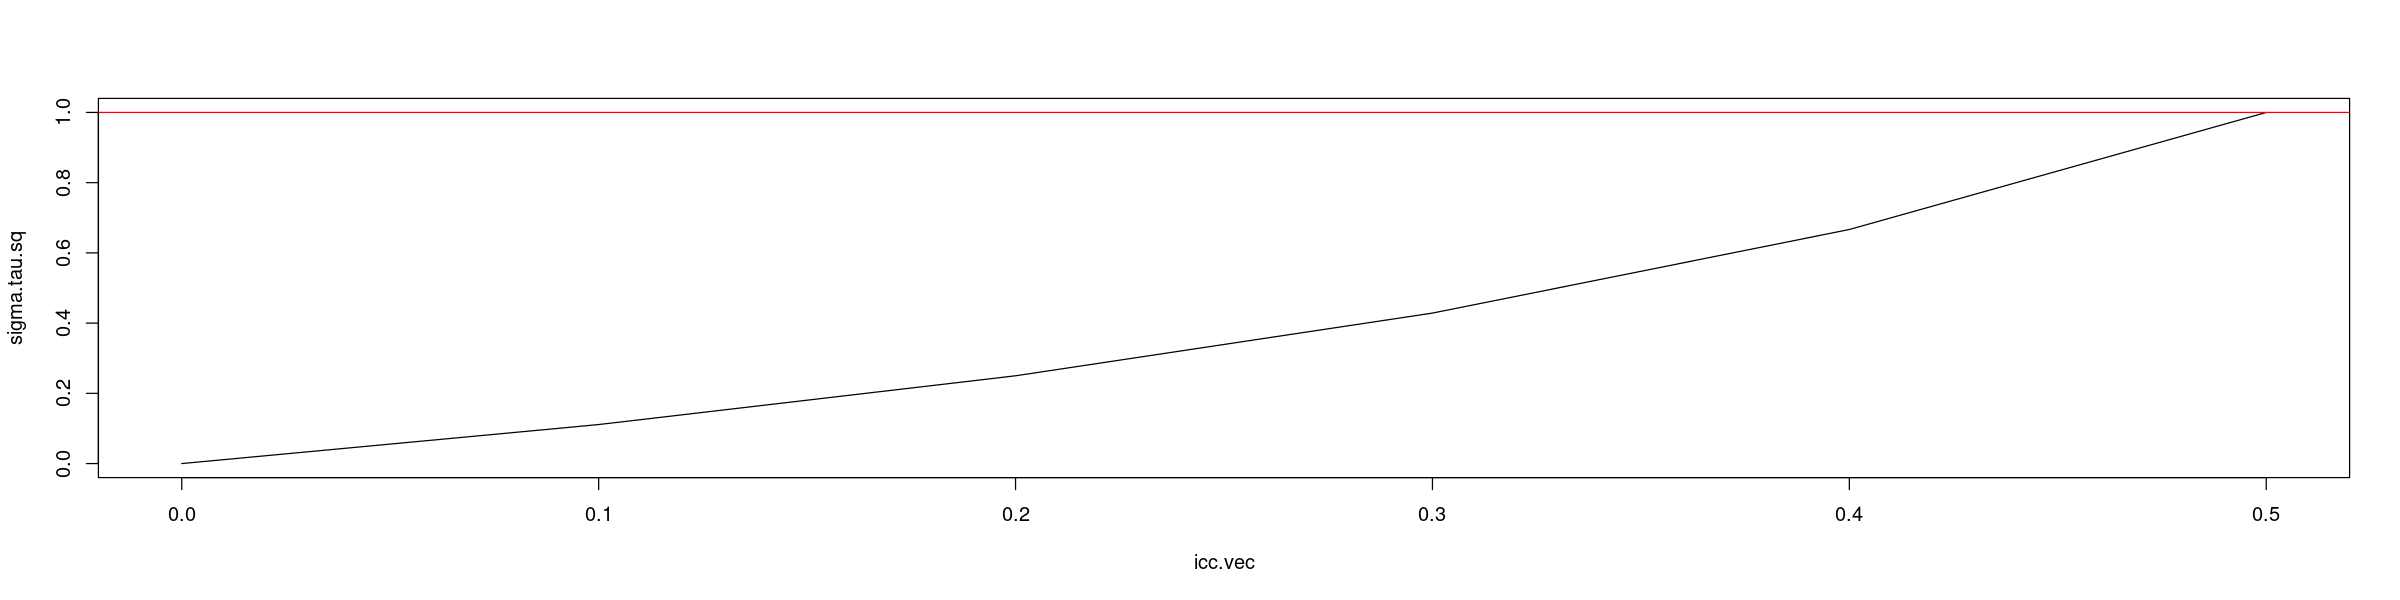

In [6]:
# How does sigma_tau behave has ICC increases? 

sigma.e=1
icc.vec=seq(0,0.5, by=0.1)
sigma.tau.sq=NULL

for(i in 1: length(icc.vec)){
    sigma.tau.sq[i]=icc.vec[i]*sigma.e/(1-icc.vec[i])

}

plot(x=icc.vec, y=sigma.tau.sq, type='l')
abline(h=1, col='red')

# So, increase in ICC imply increase in the variance of cluster random effect!

In [7]:
# Conduct cluster randomization and generate the correspond data according to model 1

options(scipen=999)
beta=0.2 # treatment effect. 
sigma_e=1
# calculate the required sample size for cluster randomization. Suppose that we have a fixed number of clusters and that there are equal number of subjects within each cluster. 
n.group1=cont.sample.size(m1=9.0,
                 m2=9.0+beta,
                 sd=sigma_e,
                 type_I_error=0.05, 
                 type_II_error=0.2)


k=10 # 10, 20, 50, 100 , the number of equal sized clusters
ni=100 # a fixed number of subjects per treatment group

# calculate the variance for cluster random effect. 
icc=0.5   #k/(n.group1) # maximum allowable icc for the current number of clusters is  k/n.group1

sigma_b=icc*sigma_e/(1-icc)

# For now, suppose we have a fixed sample size say 100 per treatment group
n.group1.clust=100       #ceiling ( (n.group1 *k*(1-icc) )/(k-n.group1*icc)  )

N=n.group1.clust*2 # total number of subject for the two treatment groups. 

N
# Generate cluster id 
cluster_id=sample(x=1:k,size=N, replace=TRUE)

# Randomize treatment to the k clusters. 
trt.cluster=rbinom(n=k,size=1, prob=0.5) 

trt=trt.cluster[cluster_id] # assign each cluster to its appropriate treatment. 

xb=beta*trt

# simulate cluster random intercept (for now)  
clust.eff=rnorm(n=k, mean=0, sigma_b) # number of clusters is k

clust.vec=clust.eff[cluster_id] # assign each cluster to its random intercept 

# sanity checks. 
table(cluster_id, trt) # make sure that no cluster has both intervention and control. 
table(clust.vec)
table(cluster_id)

# generate outcome variable yijk using equation in model 1. 
y=rnorm(N, mean=xb,  sigma_e)+clust.vec

# combine into a dataframe 

clust.df=data.frame(y=y, trt=trt, cluster_id=cluster_id, cluster_random_interc=clust.vec) # add icc, number of clusters at a later date. 


[1] 200

          trt
cluster_id  0  1
        1  19  0
        2  16  0
        3  29  0
        4  17  0
        5  19  0
        6  25  0
        7   0 24
        8   0 18
        9   0 14
        10 19  0

clust.vec
 -0.701866383664827 -0.0966379691780691  0.0680741685107229    0.25145367872838 
                 18                  14                  19                  25 
  0.251824302700206   0.275479638068053   0.372055670061381   0.398054982019239 
                 17                  19                  16                  19 
  0.798856522209642    2.01306267771619 
                 24                  29 

cluster_id
 1  2  3  4  5  6  7  8  9 10 
19 16 29 17 19 25 24 18 14 19 

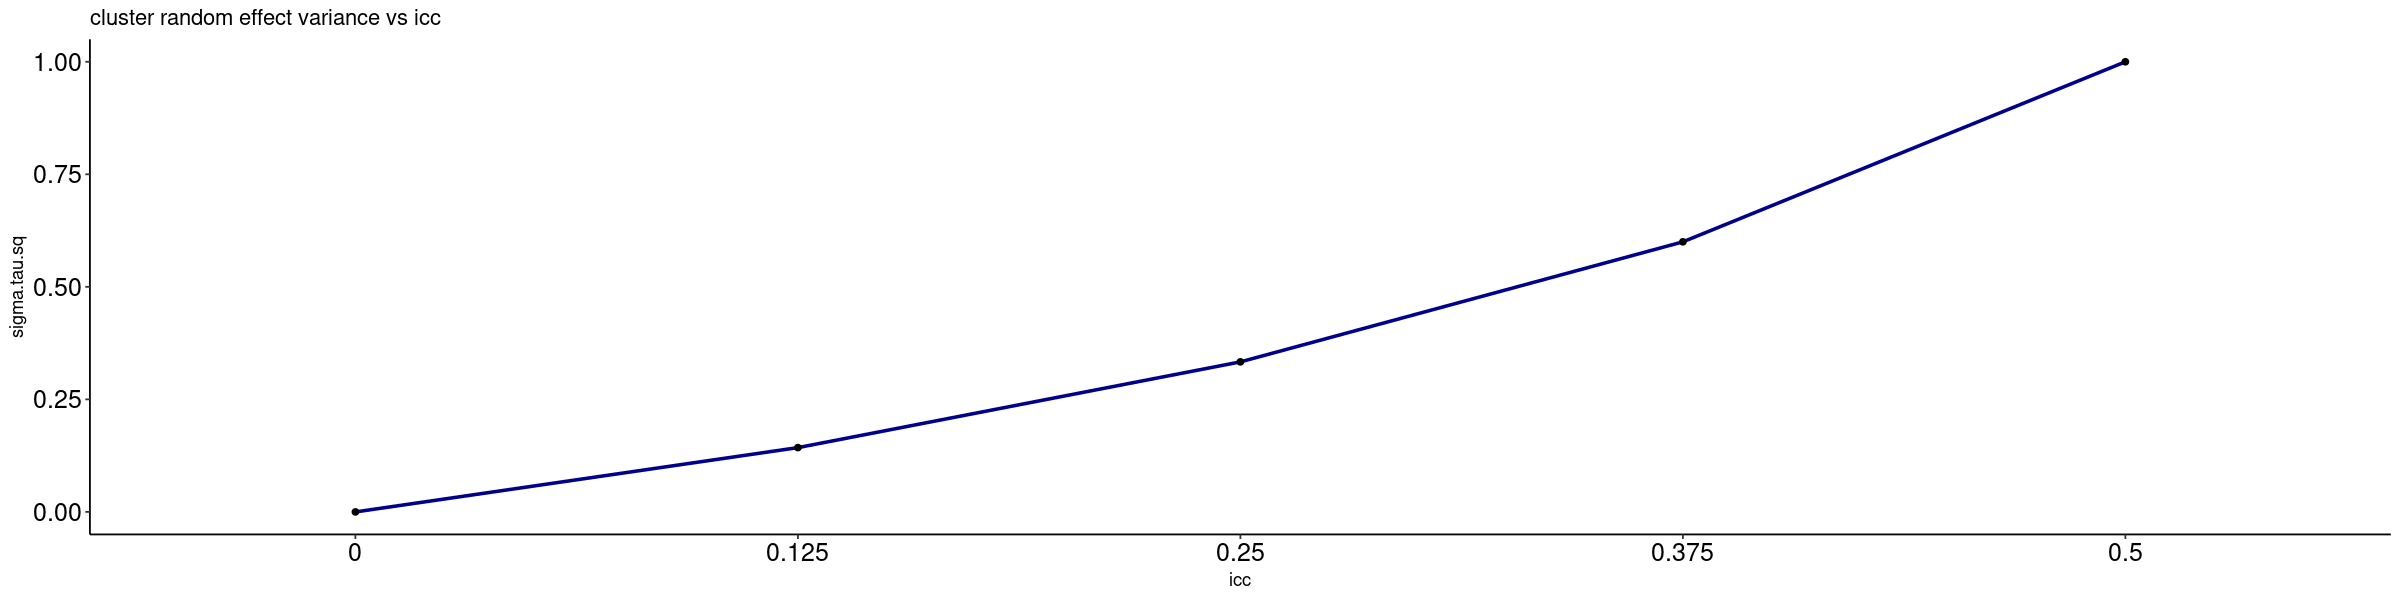

In [8]:
# Channging simulation parameters include
# 1. Number of clusters
# 2. Sample size 
# 3. ICC 

# Evaluate the impact of increasing ICC on power with fixed sample size and number of clusters 

sigma.e=1
icc.vec=seq(0,0.5, length.out=5) # icc values ranging from 0 to 0.5 
sigma.tau.sq=NULL

for(i in 1: length(icc.vec)){
    sigma.tau.sq[i]=icc.vec[i]*sigma.e/(1-icc.vec[i]) # The correspoding variance for cluster random effect
}



sigma.vs.icc.df=data.frame(icc=icc.vec, sigma.tau.sq=sigma.tau.sq)

plot.sigma=ggplot(sigma.vs.icc.df, aes(x=as.factor(icc), y=sigma.tau.sq, group=1)  )+
geom_line(color='darkblue',lwd=1.0)+
geom_point()+scale_color_brewer(palette="PuOr")+
#ylim(0,1)+
labs(x="icc",y="sigma.tau.sq")+
theme(axis.text.x = element_text(#face = "bold", 
                            color ="black", 
                           size = 15, angle = 0),
     axis.text.y = element_text(
                            color ="black", 
                           size = 15))+
ggtitle( paste0('cluster random effect variance vs icc'))+theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
panel.background = element_blank(), axis.line = element_line(colour = "black"))

plot.sigma


#ggsave(file=paste0(tab_fig_path,"cluster_random_effect_var_by_icc.svg"), plot=plot.sigma, width=15, height=5 )


In [9]:
# Emprical power vs ICC 
nsim=500
ni=400 # subjects per treatment group
beta=0.2
k=10
pwr.vs.cluster.size=function(icc){
    
    k=k # 10, 20, 50, 100 , the number of equal sized clusters
    # calculate the variance for cluster random effect. 
    icc=icc #k/(n.group1*2) # although maximum allowable icc for current number of clusters is k/n.group1
    
    sigma_b=icc*sigma_e/(1-icc)
    
    N=ni*2 #total number of subject for the two treatment groups. 
    
    # Loop over to estimate power. 
    signif.ci=NULL # significance by confidence interval. ideally, the conclusion should be the same (by duality of hypothesis test and ci) 
    sig.ind=NULL
    nsim=nsim
    for (i in 1:nsim){
        # Generate cluster id 
        cluster_id=sample(x=1:k,size=N, replace=TRUE)

        # Randomize treatment to the k clusters. 
        trt.cluster=rbinom(n=k,size=1, prob=0.5) 
        
        # arrest cases where all clusters are assigned to one treatment 
        # while(length(table(trt.cluster))!=2){
        #     trt.cluster=rbinom(n=k,size=1, prob=0.5)
        #   }


        trt=trt.cluster[cluster_id] # assign each cluster to its appropriate treatment. 

        xb=beta*trt

        # simulate cluster random intercept (for now)  
        clust.eff=rnorm(n=k, mean=0, sigma_b) # number of clusters is k

        clust.vec=clust.eff[cluster_id] # assign each cluster to its random intercept 

        # sanity checks. 
        #table(cluster_id, trt) # make sure that no cluster has both intervention and control. 
        #table(clust.vec)
        #table(cluster_id)

        # generate outcome variable yijk using equation in model 1. 
        y=rnorm(N, mean=xb,  sigma_e)+clust.vec

        # combine into a dataframe 

        clust.df=data.frame(y=y, trt=trt, cluster_id=cluster_id, cluster_random_interc=clust.vec) # add icc, number of clusters at a later date. 

        lm_mixed = suppressWarnings( suppressMessages( lmer(y ~ trt + (1| cluster_id), data = clust.df, 
                       control=lmerControl(check.conv.singular = .makeCC(action = "ignore",  tol = 1e-4))
                       ) ) )

        # Note that confint is a profile confidence interval. It is not a formal test. 
        # So, it cannot be trusted
        signif.ci[i]=any(suppressWarnings(confint(profile(lm_mixed), 'trt') )<=0) # check if we reject the null. Here, check if CI includes zero. If it does, we fail to reject the null. 
        #signif.pval[i]=pval<0.05
        
        #sig.ind[i]=t.test(y~trt, data=clust.df, var.equal=TRUE)$p.value<0.05
    }
    # The estimate power is close to the 'true' power!
    pwr.ci=1-round( sum(signif.ci)/nsim , 2)
    #pwr=round( sum(sig.ind)/nsim , 2)
    
    return(pwr.ci)
}


In [10]:
icc.mat=matrix(c(0, 0.01, 0.05, 0.1, 0.5), nrow=1)
pwr.vs.icc=apply(X=icc.mat,MARGIN=2, FUN=pwr.vs.cluster.size)

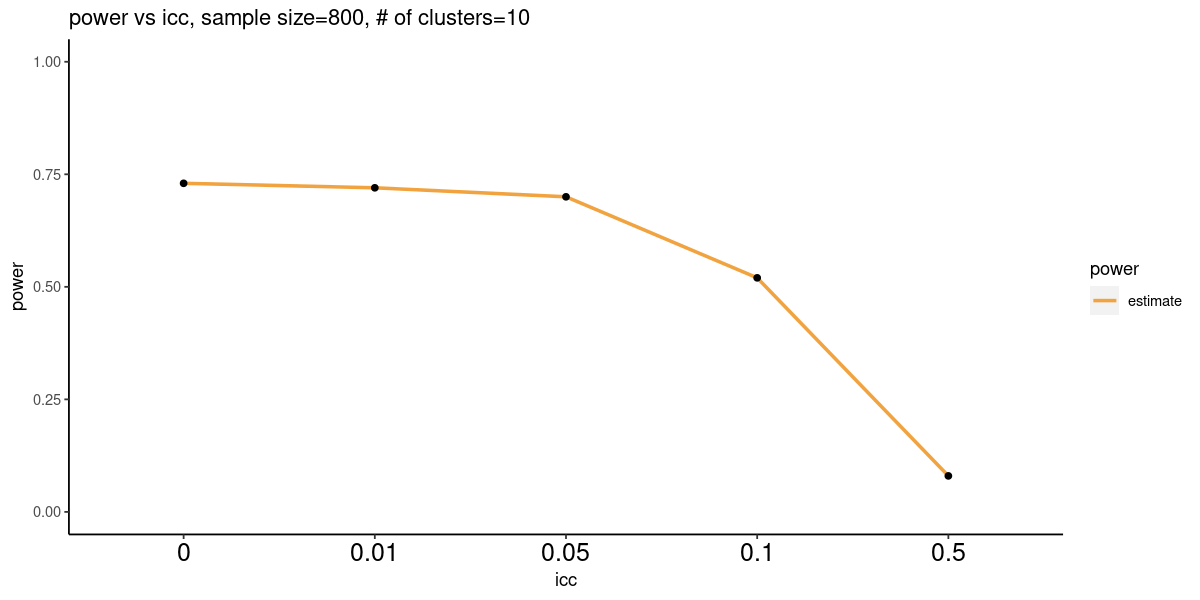

In [11]:
# Plot results 
options(repr.plot.width = 10, repr.plot.height =5) 

# combine estimated vs true power and plot. 
pwr.vs.icc.df=data.frame(icc=icc.mat[1,], pwr=pwr.vs.icc, power=rep('estimate', length(pwr.vs.icc) ))

plot6=ggplot(pwr.vs.icc.df, aes(x=as.factor(icc), y=pwr, group=power)  )+
geom_line(aes(
    color=power
), lwd=1.0)+
geom_point()+scale_color_brewer(palette="PuOr")+
ylim(0,1)+
labs(x="icc",y="power")+
theme(axis.text.x = element_text(#face = "bold", 
                            color ="black", 
                           size = 15, angle = 0))+
ggtitle( paste0('power vs icc, sample size=',ni*2,', # of clusters=', k))+theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
panel.background = element_blank(), axis.line = element_line(colour = "black"))

plot6

# we see that power decreases as icc increases. 
# Note that it is likely that this power is highly overestimated. May have to try and apply the method 
# suggested by Harrison, D. A., & Brady, A. R. (2004) in 
# 'Sample size and power calculations using the noncentral t-distribution.'

In [12]:
# Loop over increasing number of clusters

cluster.vec=c(10,20, 30, 50)
icc.mat=matrix(c(0, 0.01, 0.05, 0.1, 0.5), nrow=1)

pwr.vs.icc.df=data.frame() # empty data frame. 

for (j in 1:length(cluster.vec)){
    
    nsim=100
    ni=300 # subjects per treatment group
    beta=0.2
    k=cluster.vec[j] # increasing cluster size

    pwr.vs.icc=apply(X=icc.mat,MARGIN=2, FUN=pwr.vs.cluster.size)
    temp=data.frame(icc=icc.mat[1,], pwr=pwr.vs.icc, number.of.clusters=rep(k, length(pwr.vs.icc) ))
    pwr.vs.icc.df=rbind(pwr.vs.icc.df, temp)
}

In [13]:
pwr.vs.icc.df

icc,pwr,number.of.clusters
<dbl>,<dbl>,<dbl>
0.00,0.66,10
0.01,0.55,10
0.05,0.51,10
0.10,0.41,10
0.50,0.07,10
0.00,0.58,20
0.01,0.63,20
0.05,0.63,20
0.10,0.47,20


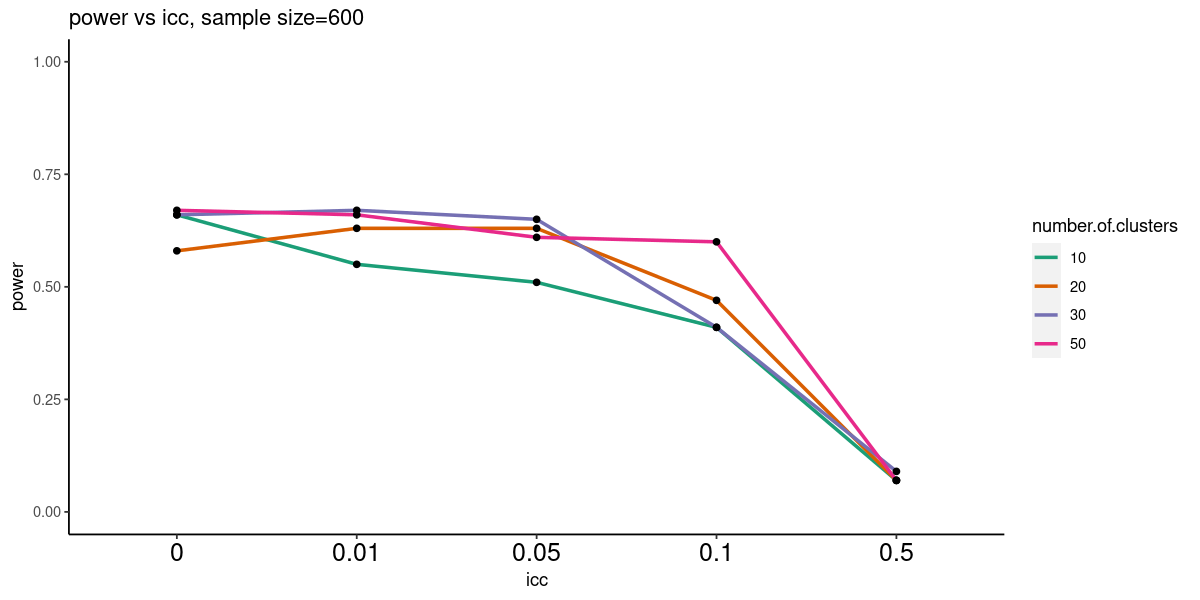

In [14]:
options(repr.plot.width = 10, repr.plot.height =5) 
pwr.vs.icc.df$number.of.clusters=as.factor(pwr.vs.icc.df$number.of.clusters)
plot7=ggplot(pwr.vs.icc.df, aes(x=as.factor(icc), y=pwr, group=as.factor(number.of.clusters))  )+
geom_line(aes(
    color=number.of.clusters
), lwd=1.0)+
geom_point()+scale_color_brewer(palette="Dark2")+
ylim(0,1)+
labs(x="icc",y="power")+
theme(axis.text.x = element_text(#face = "bold", 
                            color ="black", 
                           size = 15, angle = 0))+
ggtitle( paste0('power vs icc, sample size=',ni*2))+theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
panel.background = element_blank(), axis.line = element_line(colour = "black"))

plot7
#ggsave(file=paste0(tab_fig_path,"power_vs_icc_by_samplesize.svg"), plot=plot7, width=15, height=5 )

In [15]:

cluster.vec=c(10,20, 30, 50)
icc.mat=matrix(c(0, 0.01, 0.05, 0.1, 0.5), nrow=1)

pwr.vs.icc.df.500=data.frame() # empty data frame. 

nsim=100
ni=500 # subjects per treatment group
beta=0.2

for (j in 1:length(cluster.vec)){
    k=cluster.vec[j] # increasing cluster size

    pwr.vs.icc=apply(X=icc.mat,MARGIN=2, FUN=pwr.vs.cluster.size)
    temp=data.frame(icc=icc.mat[1,], pwr=pwr.vs.icc, number.of.clusters=rep(k, length(pwr.vs.icc) ))
    pwr.vs.icc.df.500=rbind(pwr.vs.icc.df.500, temp)
}
#ggsave(file=paste0(tab_fig_path,"power_vs_icc_by_samplesize.svg"), plot=plot7, width=15, height=5 )

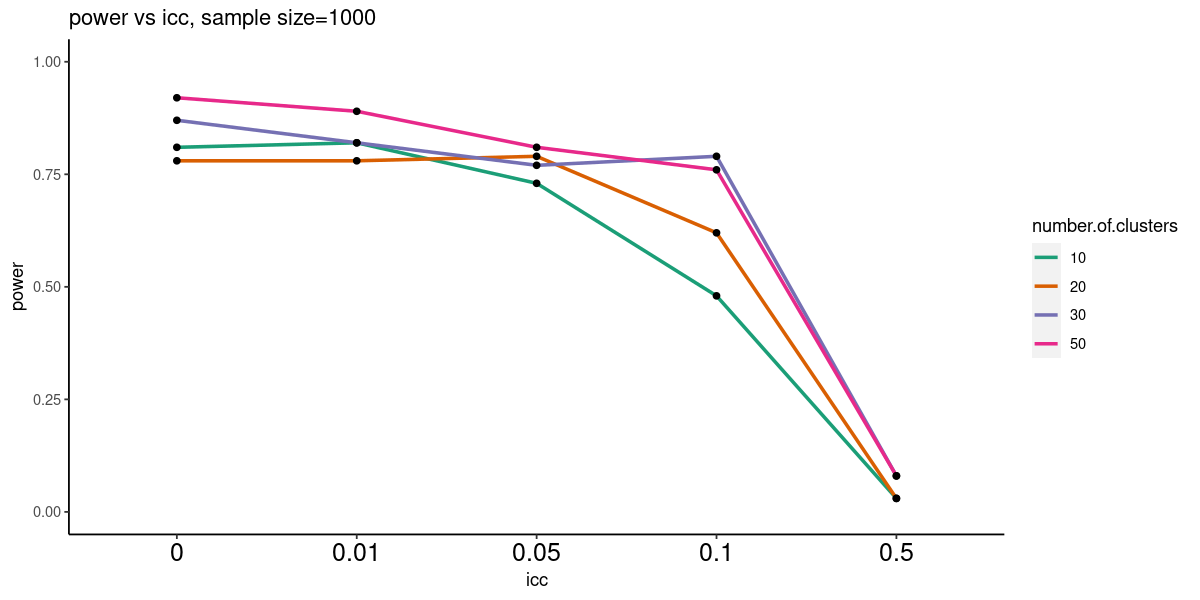

In [16]:
options(repr.plot.width = 10, repr.plot.height =5) 

pwr.vs.icc.df.500$number.of.clusters=as.factor(pwr.vs.icc.df.500$number.of.clusters)

plot8=ggplot(pwr.vs.icc.df.500, aes(x=as.factor(icc), y=pwr, group=as.factor(number.of.clusters))  )+
geom_line(aes(
    color=number.of.clusters
), lwd=1.0)+
geom_point()+scale_color_brewer(palette="Dark2")+
ylim(0,1)+
labs(x="icc",y="power")+
theme(axis.text.x = element_text(#face = "bold", 
                            color ="black", 
                           size = 15, angle = 0))+
ggtitle( paste0('power vs icc, sample size=',ni*2))+theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
panel.background = element_blank(), axis.line = element_line(colour = "black"))

plot8

In [17]:
plot7.8= arrangeGrob(plot7,plot8, nrow = 1) #generates g

ggsave(file=paste0(tab_fig_path,"power_vs_icc_by_samplesize.svg"), plot=plot7.8, width=20, height=5 )

$\Large{\textbf{Randomized patients to treatment first, then to clusters}}$

This kind of randomization scheme protects against confouders. However, it poses some significant challenges when it comes to implementation. 

My strategy to implement this kind of randomization trial.
1. Randomize patients to treatment 
2. For a fixed number of doctors, randomize them to treatment 
3. For patients in treatment==1, they can be treated only by one of the doctors assigned to only treatment==1. For patients in treatment==0, they can be treated by one of the doctors assigned to only treatment==0. 
4. Induce contamination on treatment as desired
5. Evaluate the impact on statistical power with and without contamination 
6. Investigate if include doctor's random slope  within a treatment minimizes reduction in power in the presence of contamination. 


In [18]:
# Generate data following the stragey above. It mimics a real-life clinical trial? 

options(scipen=999)
beta=0.2 # treatment effect. 
sigma_e=1
# calculate the required sample size for cluster randomization. Suppose that we have a fixed number of clusters and that there are equal number of subjects within each cluster. 
n.group1=cont.sample.size(m1=9.0,
                 m2=9.0+beta,
                 sd=sigma_e,
                 type_I_error=0.05, 
                 type_II_error=0.2)


k=10 # 10, 20, 50, 100 , the number of equal sized clusters
ni=100 # a fixed number of subjects per treatment group
N=ni*2 # total number of patients in the trial. 

# calculate the variance for cluster random effect. 
icc=0.5   #k/(n.group1) # maximum allowable icc for the current number of clusters is  k/n.group1

sigma_b=icc*sigma_e/(1-icc)

# cluster ids 
cluster.id=seq(1, k, by=1)

# Randomize patients to treatment 
trt=rbinom(n=N,size=1, prob=0.5)

# randomize clusters to treatments 
cluster.to.trt=rbinom(n=k,size=1, prob=0.5)

# extra cluster id based on assinged treatment. 
cluster.trt.one.id=cluster.id[cluster.to.trt==1]
cluster.trt.zero.id=cluster.id[cluster.to.trt==0]

# randomly assign patients to clusters/doctors such that patients in treatment==1 are assigned to doctors
# in treatment==1. 
cluster.assigment=NULL 

for(i in 1:N){

    if (trt[i]==1){
    
        cluster.assigment[i]=sample(cluster.trt.one.id, size=1)
    }else{
    cluster.assigment[i]=sample(cluster.trt.zero.id, size=1) }
}

## If assigning doctors to patients in a random fashion without conditioning on treatment assigned to
#cluster.assigment=sample(1:k, size=N, replacement=TRUE)

# # sanity checks. 
table(cluster.assigment, trt) # make sure that no cluster has both intervention and control. 
table(cluster.assigment)


# x-beta 
xb=beta*trt

# # simulate cluster random intercept (for now)  
clust.eff=rnorm(n=k, mean=0, sigma_b) # number of clusters is k

clust.eff.vec=clust.eff[cluster.assigment] # assign each cluster to its random intercept 

# # generate outcome variable yijk using equation in model 1. 
y=rnorm(N, mean=xb,  sigma_e)+clust.eff.vec

# # combine into a dataframe 

clust.df=data.frame(y=y, trt=trt, cluster.assigned=cluster.assigment, cluster_random_interc=clust.eff.vec) # add icc, number of clusters at a later date. 

head(clust.df)

                 trt
cluster.assigment  0  1
               1   0 20
               2  31  0
               3   0 13
               4   0 12
               5   0 17
               6   0 13
               7  34  0
               8  37  0
               9   0  8
               10  0 15

cluster.assigment
 1  2  3  4  5  6  7  8  9 10 
20 31 13 12 17 13 34 37  8 15 

,y,trt,cluster.assigned,cluster_random_interc
,<dbl>,<int>,<dbl>,<dbl>
1,-1.4358419,1,6,-1.2842741
2,0.2674184,1,1,0.1507544
3,2.0007483,0,7,0.1242800
4,-2.0702323,1,5,-1.4097732
5,-0.0540591,0,8,-0.5895021
6,-0.3742950,1,6,-1.2842741


In [19]:
# Emprical power vs ICC  where we randomize patients to treatment, then to clusters. 
sigma_e=1
beta=0.2
k=10
contam.rate=0.0
ni=cont.sample.size(m1=9.0,
                 m2=9.0+beta,
                 sd=sigma_e,
                 type_I_error=0.05, 
                 type_II_error=0.2)

N=ni*2
nsim=100
pwr.vs.cluster.size=function(icc){
    
    k=k # 10, 20, 50, 100 , the number of equal sized clusters
    # calculate the variance for cluster random effect. 
    icc=icc #k/(n.group1*2) # although maximum allowable icc for current number of clusters is k/n.group1
    
    sigma_b=icc*sigma_e/(1-icc)
    
    N=ni*2 #total number of subject for the two treatment groups. 
    
    # Loop over to estimate power. 
    signif.ci=NULL # significance by confidence interval. ideally, the conclusion should be the same (by duality of hypothesis test and ci) 
    
    nsim=nsim
    
    for (i in 1:nsim){
        
        # cluster ids 
        cluster.id=seq(1, k, by=1)

        # Randomize patients to treatment 
        trt=rbinom(n=N,size=1, prob=0.5)
        
        # induce contamination using option 1. 
        trt.contam=trt # create a new trt object and induce contamination according to option 1

        trt.contam[trt==0]=trt.contam[trt==0]+ rbinom(n=sum(trt==0), prob=contam.rate, size=1)

        # randomize clusters to treatments 
        cluster.to.trt=rbinom(n=k,size=1, prob=0.5)

        # extra cluster id based on assigned treatment. 
        cluster.trt.one.id=cluster.id[cluster.to.trt==1]
        cluster.trt.zero.id=cluster.id[cluster.to.trt==0]

        # randomly assign patients to clusters/doctors such that patients in treatment==1 are assigned to doctors
        # in treatment==1. 
        cluster.assigment=NULL 

        for(j in 1:N){

            if (trt[j]==1){

                cluster.assigment[j]=sample(cluster.trt.one.id, size=1)
            }else{
            cluster.assigment[j]=sample(cluster.trt.zero.id, size=1) }
        }


        # # sanity checks. 
        # table(cluster.assigment, trt) # make sure that no cluster has both intervention and control. 
        # table(cluster.assigment)


        # x-beta with or without contamination. 
        if (contam.rate>0){
        xb=beta*trt.contam}else{
        xb=beta*trt
        }

        # # simulate cluster random intercept (for now)  
        clust.eff=rnorm(n=k, mean=0, sigma_b) # number of clusters is k

        clust.eff.vec=clust.eff[cluster.assigment] # assign each cluster to its random intercept 

        # # generate outcome variable yijk using equation in model 1. 
        y=rnorm(N, mean=xb,  sigma_e)+clust.eff.vec

        # # combine into a dataframe 

        clust.df=data.frame(y=y, trt=trt, cluster.assigned=cluster.assigment,
                            cluster_random_interc=clust.eff.vec) # add icc, number of clusters at a later date. 

        lm_mixed = suppressWarnings( suppressMessages( lmer(y ~ trt + (1| cluster.assigned), 
                                                            data = clust.df, 
                       control=lmerControl(check.conv.singular = .makeCC(action = "ignore",  
                                                                         tol = 1e-4))
                       ) ) )
        
        # lm_mixed.with.rand.slope= suppressWarnings( suppressMessages( lmer(y ~ trt + (1+trt| cluster.assigned), 
        #                                                             data = clust.df, 
        #                        control=lmerControl(check.conv.singular = .makeCC(action = "ignore",  
        #                                                                          tol = 1e-4))
        #                        ) ) )
        # Note that confint is a profile confidence interval. It is not a formal test. 
        # So, it cannot be trusted
        
        signif.ci[i]=any(suppressWarnings(confint(profile(lm_mixed), 'trt') )<=0) # check if we reject the null. Here, check if CI includes zero. If it does, we fail to reject the null. 
        #signif.ci[i]=any(suppressWarnings(confint(profile(lm_mixed.with.rand.slope), 'trt') )<=0) 
    }
    # The estimate power is close to the 'true' power!
    pwr.ci=1-round( sum(signif.ci)/nsim , 2)
    
    return(pwr.ci)
}

In [20]:
sigma_e=1
beta=0.2
k=10
contam.rate=0.0
ni=cont.sample.size(m1=9.0,
                 m2=9.0+beta,
                 sd=sigma_e,
                 type_I_error=0.05, 
                 type_II_error=0.2)

nsim=100
N=ni*2

#c(0, 0.01, 0.05, 0.1, 0.5)
icc.mat=matrix(c(0, 0.01, 0.05, 0.1, 0.5), nrow=1)

pwr.vs.icc=apply(X=icc.mat,MARGIN=2, FUN=pwr.vs.cluster.size)

In [21]:
pwr.vs.icc

[1] 0.77 0.82 0.69 0.49 0.10

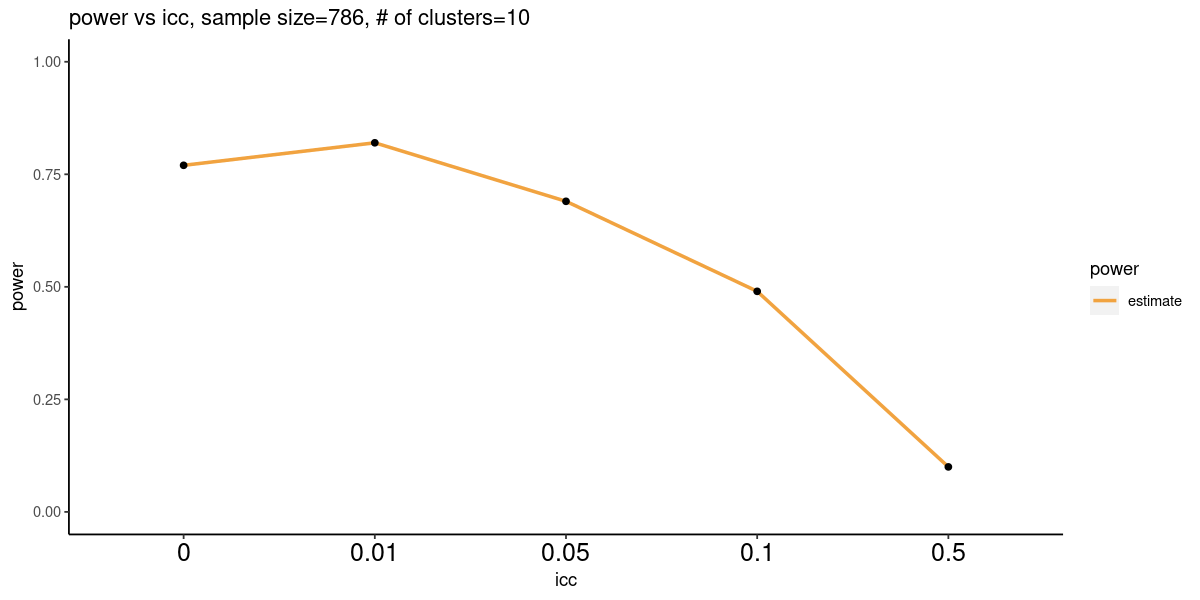

In [22]:
# Plot results 

options(repr.plot.width = 10, repr.plot.height =5) 

# combine estimated vs true power and plot. 
pwr.vs.icc.df=data.frame(icc=icc.mat[1,], pwr=pwr.vs.icc, power=rep('estimate', length(pwr.vs.icc) ))

plot.trt.then.cluster=ggplot(pwr.vs.icc.df, aes(x=as.factor(icc), y=pwr, group=power)  )+
geom_line(aes(
    color=power
), lwd=1.0)+
geom_point()+scale_color_brewer(palette="PuOr")+
ylim(0,1)+
labs(x="icc",y="power")+
theme(axis.text.x = element_text(#face = "bold", 
                            color ="black", 
                           size = 15, angle = 0))+
ggtitle( paste0('power vs icc, sample size=',ni*2,', # of clusters=', k))+theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
panel.background = element_blank(), axis.line = element_line(colour = "black"))

plot.trt.then.cluster

# We see that power decreases as icc increases. Assigning patients to treatment first and then cluster
# produces similar results but not exact. 

# For this kind of scenario, I can induce contamination and see how that affects power estimation. 

$\Large{\textbf{Cluster rct with clinician's induced contamination}}$

Evaluate the impact of clinicians seeing patients in both control and intervention. Under such a scenario, we expect some level of contamination even though the trial is cluster rct. 

Investigate if including clinician as a random effect and adding random slope by treatment minimizes on the loss of statistical power when we have contamination. 

In appears as though this is the kind of design that aligns with the one from Min and Bin. Now, instead of randomly assigning doctors to patients conditioned on treatment assignment, assign the patients to doctors in a random fashion. It is clear that there is going to be contamination. Unfortunately, we end up losing information on the directionality of the bais. 

Is it still possible to estimate a debiased treatment effect under these settings? Bin is going to walk us through his taught process and how we can simulate data under this scenario and whether we can estimate the treatment effect. 

From my conversation with Min and Bin, Bin suggested treating the contamination rate as a random variable as opposed to a fixed unkown value. He pondered whether one can then estimate this contamination rate from the observed data. 



In [23]:
sigma_e=1
beta=0.2
k=10
contam.rate=0.3
ni=cont.sample.size(m1=9.0,
                 m2=9.0+beta,
                 sd=sigma_e,
                 type_I_error=0.05, 
                 type_II_error=0.2)

nsim=100

#c(0, 0.01, 0.05, 0.1, 0.5)
icc.mat=matrix(c(0, 0.01, 0.05, 0.1, 0.5), nrow=1)

In [24]:
pwr.vs.icc.contam=apply(X=icc.mat,MARGIN=2, FUN=pwr.vs.cluster.size)

pwr.vs.icc.contam

[1] 0.45 0.54 0.35 0.29 0.03

In [25]:
pwr.vs.icc.df=data.frame(icc=icc.mat[1,], pwr=pwr.vs.icc, 
                         power=rep('without contamination', length(pwr.vs.icc) ))

pwr.vs.icc.df2=data.frame(icc=icc.mat[1,], pwr=pwr.vs.icc.contam, 
                         power=rep('with contamination', length(pwr.vs.icc) ))

pwr.vs.icc.contam.df=rbind(pwr.vs.icc.df,pwr.vs.icc.df2 )

pwr.vs.icc.contam.df

icc,pwr,power
<dbl>,<dbl>,<chr>
0.00,0.77,without contamination
0.01,0.82,without contamination
0.05,0.69,without contamination
0.10,0.49,without contamination
0.50,0.10,without contamination
0.00,0.45,with contamination
0.01,0.54,with contamination
0.05,0.35,with contamination
0.10,0.29,with contamination


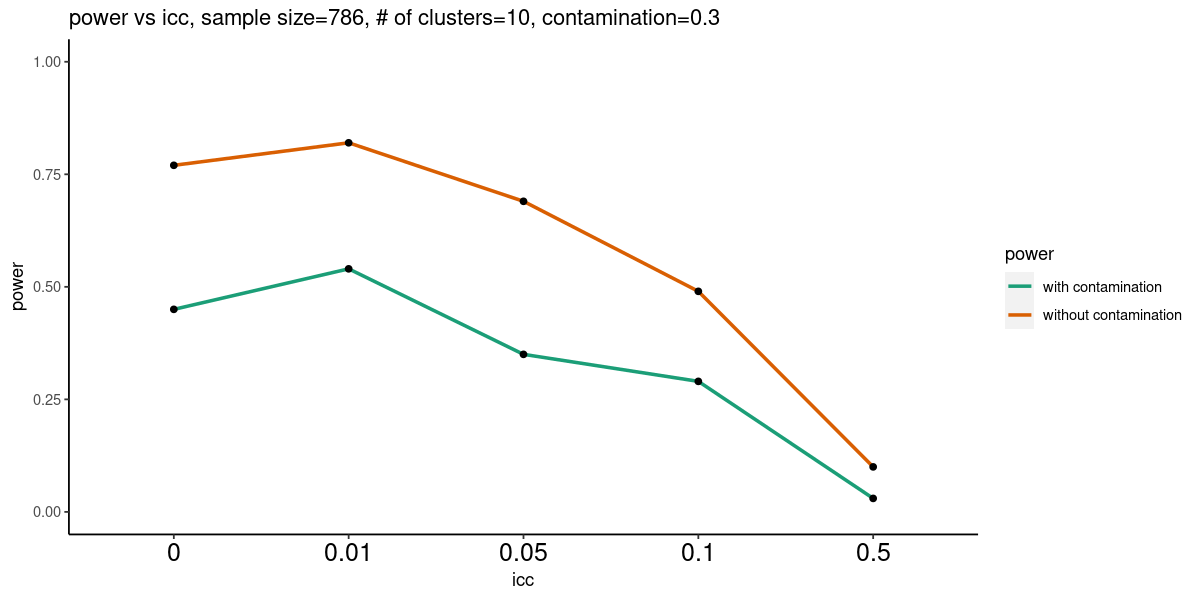

In [26]:
# Plot results 

options(repr.plot.width = 10, repr.plot.height =5) 

plot.trt.then.cluster.with.contam=ggplot(pwr.vs.icc.contam.df, aes(x=as.factor(icc), y=pwr, group=power)  )+
geom_line(aes(
    color=power
), lwd=1.0)+
geom_point()+scale_color_brewer(palette="Dark2")+
ylim(0,1)+
labs(x="icc",y="power")+
theme(axis.text.x = element_text(#face = "bold", 
                            color ="black", 
                           size = 15, angle = 0))+
ggtitle( paste0('power vs icc, sample size=',ni*2,', # of clusters=', k, ', contamination=', 
               contam.rate))+theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
panel.background = element_blank(), axis.line = element_line(colour = "black"))

plot.trt.then.cluster.with.contam

# We lose significant power when there's substantial contamination even with cluster randomization. 

 #ggsave(file=paste0(tab_fig_path,"power_vs_icc_by_contamination.svg"), plot=plot.trt.then.cluster.with.contam, width=10, height=5 )

$\textbf{Randomly assign doctors to patients without conditioning on treatment}$

Strategy 
1. Randomize individuals to treatment 
2. Assign doctors/clusters to patients in a random fashion. With this randomization scheme, it is almost guaranteed that some doctors will be assigned to patients in both control and intervention. The scheme induces an intrinsic contamination. 
3. Extract contaminated treatment variable
4. Use contaminated treatment variable to generate Y 
5. Generate compliance variable 
6. Compile the simulated variables into a data frame, making sure that the treatment variable is from the first step. Because that is what we would observe at the end of the trial. 
7. Estimate statistical power with and without the compliance variable. 

In [27]:
# Generate data following the stragey above. It reflects the settings in UTI data from Min. 

options(scipen=999)
beta=0.2 # treatment effect. 
sigma_e=1
# calculate the required sample size for cluster randomization. Suppose that we have a fixed number of clusters and that there are equal number of subjects within each cluster. 
n.group1=cont.sample.size(m1=9.0,
                 m2=9.0+beta,
                 sd=sigma_e,
                 type_I_error=0.05, 
                 type_II_error=0.2)


k=10 # 10, 20, 50, 100 , the number of equal sized clusters
ni=100 # a fixed number of subjects per treatment group
N=ni*2 # total number of patients in the trial. 

# calculate the variance for cluster random effect. 
icc=0.5   #k/(n.group1) # maximum allowable icc for the current number of clusters is  k/n.group1

sigma_b=icc*sigma_e/(1-icc)


# Randomize patients to treatment 
trt=rbinom(n=N,size=1, prob=0.5)

## If assigning doctors to patients in a random fashion without conditioning on treatment assigned to
cluster.assigment=sample(1:k, size=N, replace=TRUE)

## Extract proportion of intervention for each doctor/cluster
cross.in.prop=as.vector( prop.table( table(cluster.assigment, trt), margin=1)[,2] ) # 

## Assign these proportions to doctors 
interven.prop.vec=cross.in.prop[cluster.assigment]

## If proportion of controls with a doctor is > 0.5, given all the patients 
# in that cluster intervention, otherwise keep the current treatment. 
trt.contam=trt

trt.contam[interven.prop.vec>0.5]=1 # tipping point. 

compliance=(trt.contam==trt)*1 # complaince variance 

table(compliance)
# # x-beta 
xb=beta*trt.contam # make sure to use the treatment variable that acts behind the scene!

# # simulate cluster random intercept (for now)  
clust.eff=rnorm(n=k, mean=0, sigma_b) # number of clusters is k

clust.eff.vec=clust.eff[cluster.assigment] # assign each cluster to its random intercept 

# # generate outcome variable yijk using equation in model 1. 
y=rnorm(N, mean=xb,  sigma_e)+clust.eff.vec

# # combine into a dataframe 

clust.df=data.frame(y=y, trt=trt, compliance=compliance, cluster.assigned=cluster.assigment, 
                    cluster_random_interc=clust.eff.vec) # add icc, number of clusters at a later date. 

head(clust.df)

compliance
  0   1 
 32 168 

,y,trt,compliance,cluster.assigned,cluster_random_interc
,<dbl>,<int>,<dbl>,<int>,<dbl>
1,-0.382814961,0,0,1,0.9745812
2,-0.994228589,0,1,3,-0.8030315
3,0.223766989,1,1,6,-0.2422453
4,0.775484384,0,1,10,0.8296064
5,-1.128624233,1,1,2,-1.1979740
6,-0.006074232,1,1,10,0.8296064


In [28]:
# Emprical power vs ICC  where we randomize patients to treatment, then to clusters. 
sigma_e=1
beta=0.2
k=10
contam.rate=0.0
ni=cont.sample.size(m1=9.0,
                 m2=9.0+beta,
                 sd=sigma_e,
                 type_I_error=0.05, 
                 type_II_error=0.2)

N=ni*2
nsim=100
tipping.point=0.5
complied=FALSE
pwr.vs.cluster.sizeB=function(icc){
    
    k=k # 10, 20, 50, 100 , the number of equal sized clusters
    # calculate the variance for cluster random effect. 
    icc=icc #k/(n.group1*2) # although maximum allowable icc for current number of clusters is k/n.group1
    
    sigma_b=icc*sigma_e/(1-icc)
    
    N=ni*2 #total number of subject for the two treatment groups. 
    
    # Loop over to estimate power. 
    signif.ci=NULL # significance by confidence interval. ideally, the conclusion should be the same (by duality of hypothesis test and ci) 
    
    nsim=nsim
    
    for (i in 1:nsim){

               # Randomize patients to treatment 
        trt=rbinom(n=N,size=1, prob=0.5)

        ## If assigning doctors to patients in a random fashion without conditioning on treatment assigned to
        cluster.assigment=sample(1:k, size=N, replace=TRUE)

        ## Extract proportion of intervention for each doctor/cluster
        cross.in.prop=as.vector( prop.table( table(cluster.assigment, trt), margin=1)[,2] ) # 

        ## Assign these proportions to doctors 
        interven.prop.vec=cross.in.prop[cluster.assigment]

        ## If proportion of controls with a doctor is > 0.5, given all the patients 
        # in that cluster intervention, otherwise keep the current treatment. 
        trt.contam=trt
        trt.contam[interven.prop.vec>tipping.point]=1 # tipping point. 
        
        # Generate compliance variable 
        compliance=(trt.contam==trt)*1 # complaince variance 


        # # x-beta 
        xb=beta*trt.contam # make sure to use the treatment variable that acts behind the scene!

        # # simulate cluster random intercept (for now)  
        clust.eff=rnorm(n=k, mean=0, sigma_b) # number of clusters is k

        clust.eff.vec=clust.eff[cluster.assigment] # assign each cluster to its random intercept 

        # # generate outcome variable yijk using equation in model 1. 
        y=rnorm(N, mean=xb,  sigma_e)+clust.eff.vec

        # # combine into a dataframe 

        clust.df=data.frame(y=y, trt=trt, compliance=compliance,
                            cluster.assigned=cluster.assigment, cluster_random_interc=clust.eff.vec) # add icc, number of clusters at a later date. 

        if(complied){
        lm_mixed = suppressWarnings( suppressMessages( lmer(y ~ trt + compliance+(1| cluster.assigned), 
                                                            data = clust.df, 
                       control=lmerControl(check.conv.singular = .makeCC(action = "ignore",  
                                                                         tol = 1e-4))
                       ) ) )}else{
        
       lm_mixed = suppressWarnings( suppressMessages( lmer(y ~ trt + (1| cluster.assigned), 
                                                        data = clust.df, 
                   control=lmerControl(check.conv.singular = .makeCC(action = "ignore",  
                                                                     tol = 1e-4))
                   ) ) )}
        
        # Note that confint is a profile confidence interval. It is not a formal test. 
        # So, it cannot be trusted
        
        signif.ci[i]=any(suppressWarnings(confint(profile(lm_mixed), 'trt') )<=0) # check if we reject the null. Here, check if CI includes zero. If it does, we fail to reject the null. 
        #signif.ci[i]=any(suppressWarnings(confint(profile(lm_mixed.with.rand.slope), 'trt') )<=0) 
    }
    # The estimate power is close to the 'true' power!
    pwr.ci=1-round( sum(signif.ci)/nsim , 2)
    
    return(pwr.ci)
}

In [29]:
sigma_e=1
beta=0.2
k=10
contam.rate=0.0
ni=cont.sample.size(m1=9.0,
                 m2=9.0+beta,
                 sd=sigma_e,
                 type_I_error=0.05, 
                 type_II_error=0.2)

N=ni*2
nsim=100
tipping.point=0.5
complied=TRUE
#c(0, 0.01, 0.05, 0.1, 0.5)
icc.mat=matrix(c(0, 0.01, 0.05, 0.1, 0.5), nrow=1)

pwr.vs.iccB=apply(X=icc.mat,MARGIN=2, FUN=pwr.vs.cluster.sizeB)

In [30]:
pwr.vs.iccB; N

# adding complaince variable improves on power estimation. 

[1] 0.64 0.66 0.74 0.66 0.49

[1] 786

In [31]:
tipping.point.vec=c(0.3, 0.5, 0.6, 0.7, 0.9)
icc.mat=matrix(c(0, 0.01, 0.05, 0.1, 0.5), nrow=1)

pwr.vs.icc.tipping.point.df=data.frame() # empty data frame. 

nsim=100
ni=500 # subjects per treatment group
beta=0.2
k=10

for (j in 1:length(tipping.point.vec)){
    tipping.point=tipping.point.vec[j] # increasing cluster size
    pwr.vs.iccB=apply(X=icc.mat,MARGIN=2, FUN=pwr.vs.cluster.sizeB)
    temp=data.frame(icc=icc.mat[1,], pwr=pwr.vs.iccB, tipping.point=rep(tipping.point, length(pwr.vs.iccB) ))
    pwr.vs.icc.tipping.point.df=rbind(pwr.vs.icc.tipping.point.df, temp)
}

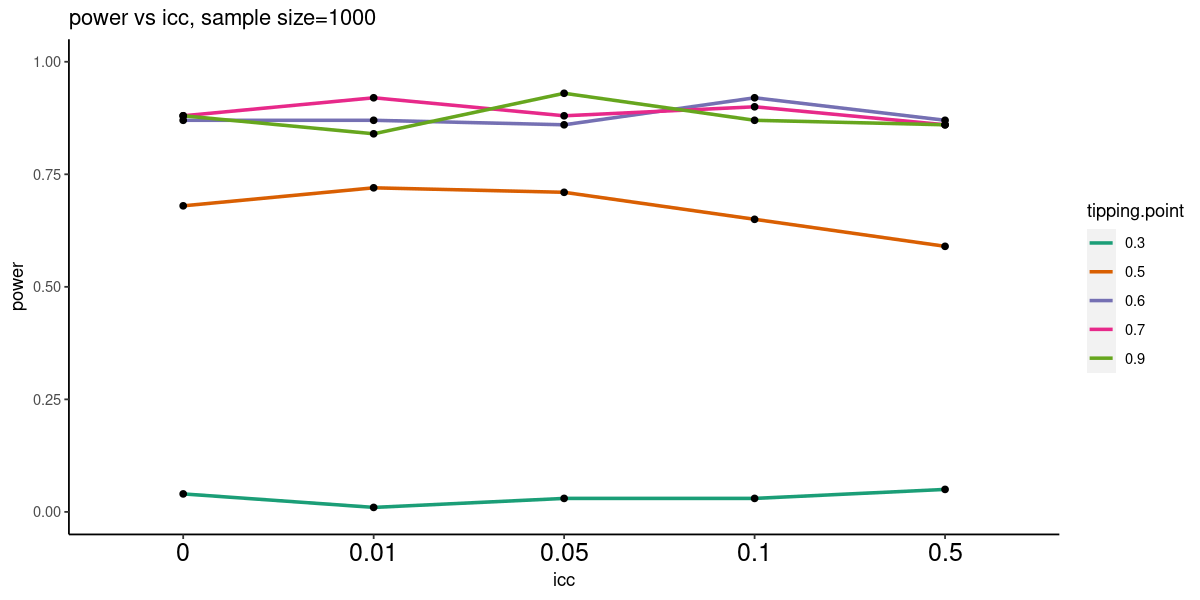

In [32]:
options(repr.plot.width = 10, repr.plot.height =5) 

pwr.vs.icc.tipping.point.df$tipping.point=as.factor(pwr.vs.icc.tipping.point.df$tipping.point)

plot.tipping.point=ggplot(pwr.vs.icc.tipping.point.df, aes(x=as.factor(icc), y=pwr, group=tipping.point)  )+
geom_line(aes(
    color=tipping.point
), lwd=1.0)+
geom_point()+scale_color_brewer(palette="Dark2")+
ylim(0,1)+
labs(x="icc",y="power")+
theme(axis.text.x = element_text(#face = "bold", 
                            color ="black", 
                           size = 15, angle = 0))+
ggtitle( paste0('power vs icc, sample size=',ni*2))+theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
panel.background = element_blank(), axis.line = element_line(colour = "black"))

plot.tipping.point

ggsave(file=paste0(tab_fig_path,"power_vs_icc_by_tipping.point.svg"), plot=plot.tipping.point, width=10, height=5 )
# The statistical power is consistent with the true value for tipping points above 0.5. 
# There is a significant power loss for low tipping points. 
# Could adding compliance variable mitigate the power loss? 

In [ ]:
tipping.point.vec=c(0.3, 0.5, 0.6, 0.7, 0.9)
icc.mat=matrix(c(0, 0.01, 0.05, 0.1, 0.5), nrow=1)

pwr.vs.icc.tipping.point.dfB=data.frame() # empty data frame. 

nsim=100
ni=500 # subjects per treatment group
beta=0.2
k=10
complied=TRUE

for (j in 1:length(tipping.point.vec)){
    tipping.point=tipping.point.vec[j] # increasing cluster size
    pwr.vs.iccB=apply(X=icc.mat,MARGIN=2, FUN=pwr.vs.cluster.sizeB)
    temp=data.frame(icc=icc.mat[1,], pwr=pwr.vs.iccB, tipping.point=rep(tipping.point, length(pwr.vs.iccB) ))
    pwr.vs.icc.tipping.point.dfB=rbind(pwr.vs.icc.tipping.point.dfB, temp)
}

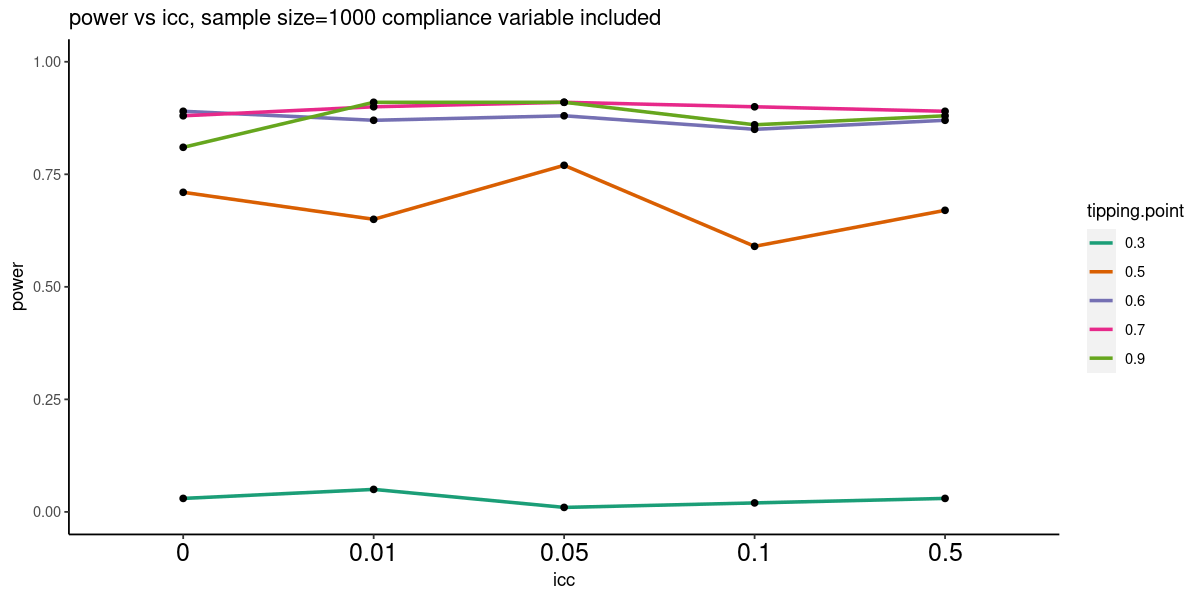

In [36]:
options(repr.plot.width = 10, repr.plot.height =5) 

pwr.vs.icc.tipping.point.dfB$tipping.point=as.factor(pwr.vs.icc.tipping.point.dfB$tipping.point)

plot.tipping.pointB=ggplot(pwr.vs.icc.tipping.point.dfB, aes(x=as.factor(icc), y=pwr, group=tipping.point)  )+
geom_line(aes(
    color=tipping.point
), lwd=1.0)+
geom_point()+scale_color_brewer(palette="Dark2")+
ylim(0,1)+
labs(x="icc",y="power")+
theme(axis.text.x = element_text(#face = "bold", 
                            color ="black", 
                           size = 15, angle = 0))+
ggtitle( paste0('power vs icc, sample size=',ni*2, ' compliance variable included'))+theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
panel.background = element_blank(), axis.line = element_line(colour = "black"))

plot.tipping.pointB

In [37]:
plot.tipping.pointAB= arrangeGrob(plot.tipping.point,plot.tipping.pointB, nrow = 1) #generates g

ggsave(file=paste0(tab_fig_path,"power_vs_icc_with_complaince_by_tipping_point.svg"), plot=plot.tipping.pointAB, width=20, height=5 )